In [89]:
%matplotlib inline
import numpy as np
import pandas as pd
import nibabel as nib 
import os
import matplotlib.pyplot as plt
import tkinter
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [112]:
def show_slices(img, slices, title=None, heatmap=None):
    if title:
        title = title
    else:
        title=''
    if heatmap:
        heatmap=heatmap
    else:
        heatmap = 'binary'
    

    """ Function to display row of image slices """
    x, y, z = slices
    slices = [img[x, :,:], img[:, y, :], img[:, :, z]]
    fig, axes = plt.subplots(1, len(slices))
    order_title = ['sagittal', 'coronal', 'horizonal']
    
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap=heatmap, origin="lower")
        full_t = title + ' '+ order_title[i]
        axes[i].set_title(full_t)
        
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = axes[i].imshow(slice.T, cmap=heatmap, origin="lower")
    fig.colorbar(im,cax=cax, orientation='vertical')
    plt.show()



        

In [66]:
# set lesion mask directory
lesionmask_dir = '/Users/emilyolafson/GIT/ENIGMA/data/lesionmasks/all_lesionmasks_2009tov6_usingSym_rename/'

# load stroke demog data
enigma=pd.read_csv('/Users/emilyolafson/GIT/ENIGMA/enigma_disconnections/cortical_atrophy/data/Behaviour_Information_ALL_April7_2022.csv', header=0)

sublist = os.listdir(lesionmask_dir)
niftis=[]
sublist_ids=[]
niftis_array=np.zeros(shape=(182, 218, 182,1))
vol=[]
for sub in sublist:
    subject=enigma[enigma['BIDS_ID']==sub[0:12]].reindex()
    istrue = subject['LESIONED_HEMISPHERE']==1
    if istrue.iloc[0]: #only keep subjects w left hemisphere stroke.
        #niftis.append(nib.load(lesionmask_dir + sub))
        sublist_ids.append(sub[0:12])
        imgfile = nib.load(lesionmask_dir + sub).get_fdata()
        
        vol.append(np.sum(imgfile>0))
        #niftis_array= np.append(niftis_array, np.reshape(nib.load(lesionmask_dir + sub).get_fdata(), [182, 218, 182, 1]),axis=3)
        # whatever. building this in matlab bc jupyter notebook is too slow with matrices.
        
#np.savetxt('/Users/emilyolafson/GIT/ENIGMA/enigma_disconnections/lefthem_lesion_arraysublist.txt', sublist_ids, fmt='%s')
#np.save('/Users/emilyolafson/GIT/ENIGMA/enigma_disconnections/lefthem_lesion_array.npy', niftis_array) # save the big matrix


515
Average N voxels: 25674.86213592233
Median N voxels: 6192.0


(array([402.,  53.,  26.,  16.,   9.,   5.,   3.,   0.,   0.,   1.]),
 array([     0. ,  35094.6,  70189.2, 105283.8, 140378.4, 175473. ,
        210567.6, 245662.2, 280756.8, 315851.4, 350946. ]),
 <BarContainer object of 10 artists>)

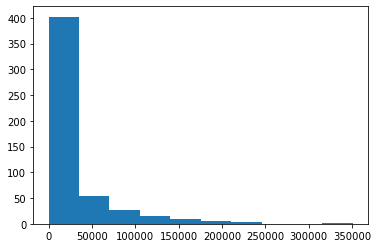

In [67]:
print(len(vol))
print('Average N voxels: {}'.format(np.mean(vol)))
print('Median N voxels: {}'.format(np.median(vol)))
plt.hist(vol)

In [69]:
#print(niftis_array.shape)
niftis_array = np.load('/Users/emilyolafson/GIT/ENIGMA/enigma_disconnections/lefthem_lesion_array.npy') # save the big matrix


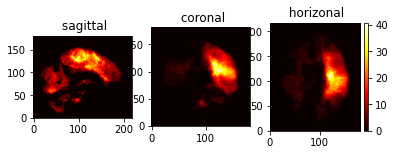

In [113]:
# plot frequency of of left hemisphere lesions
img=np.sum(niftis_array, axis=3)
show_slices(img, [100,100,100],heatmap='hot')

3D array dimensionality: (182, 218, 182)
Total number of voxels in 3D array: 7221032
Number of voxels corresponding to brain tissue: 1827095


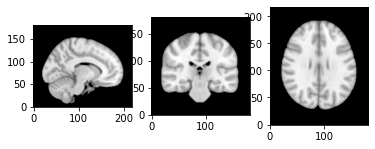

In [20]:
# load mni v6 template.
mni_template = nib.load('/usr/local/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz').get_fdata()
show_slices(mni_template, [100, 100, 100])
sum_voxels = np.sum(mni_template==0)+np.sum(mni_template>0)
print('3D array dimensionality: ({}, {}, {})'.format(mni_template.shape[0], mni_template.shape[1], mni_template.shape[2]))
print('Total number of voxels in 3D array: {}'.format(sum_voxels))
print('Number of voxels corresponding to brain tissue: {}'.format(np.sum(mni_template>0)))


Number of voxels in region 1 (BA39): 1139
Number of voxels in region 2 (BA44): 3350


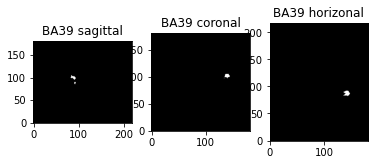

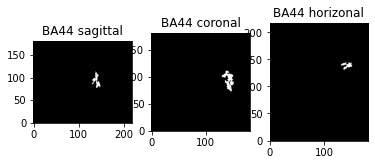

In [54]:
# load brodmann area template.
# ba 39 (no equiv). but inferior parietal lobe PF cm = J 29/30 
# ba 44 = J 13(L)/14(R)

atlas = nib.load('/usr/local/fsl/data/atlases/Juelich/Juelich-maxprob-thr50-1mm.nii.gz')
atlas = atlas.get_fdata()
atlasba39 = atlas == 29
atlasba44 = atlas == 13

show_slices(atlasba39, [142,84,100], 'BA39')

print('Number of voxels in region 1 (BA39): {}'.format(np.sum(atlasba39>0)))
      

show_slices(atlasba44, [142,140,100], 'BA44')
print('Number of voxels in region 2 (BA44): {}'.format(np.sum(atlasba44>0)))

size_ba39 = np.sum(np.array(atlasba39,dtype=bool))
size_ba44 = np.sum(np.array(atlasba44,dtype=bool))


In [200]:
# generate simulated deficit meaures for each subejct 
counter = 0
deficit=np.zeros(shape=len(niftis))
for sub in niftis:
    
    sub_data=sub.get_fdata()
    subjid = sublist_ids[counter]
    
    # overlap between lesion and brodmann areas
    overlap39 = np.sum(sub_data*atlasba39)/size_ba39
    overlap44 = np.sum(sub_data*atlasba44)/size_ba44
    
    # if more than 20% of the voxels in either ba39 or ba44 are damaged, subj has deficit with 90% probability
    if (overlap39 > .20) or (overlap44 > .20):
        rand_draw = np.random.uniform(0, 1)
        if rand_draw < 0.9:
            deficit[counter]=1
        else:
            deficit[counter]=0
    else:
        deficit[counter]=0
    counter = counter +1

In [201]:
print(deficit.shape)
print(deficit)

(515,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0